In [3]:
import ccxt
import pandas as pd
import numpy as np
import ta
from datetime import datetime, timedelta
from sklearn.model_selection import TimeSeriesSplit
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt











In [4]:
# Initialize the exchange
exchange = ccxt.binance()

# Function to fetch OHLCV data
def fetch_ohlcv(symbol, timeframe='1s', since=None):
    ohlcv = exchange.fetch_ohlcv(symbol, timeframe, since=since)
    dataframe = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
    dataframe['timestamp'] = pd.to_datetime(dataframe['timestamp'], unit='ms')
    
    dataframe.set_index('timestamp', inplace=True)
    return dataframe


Data for BTC/USDT after dropping NaN values:
(301, 10)
Features (X) and target (y):
(301, 9) (301,)
Mean squared error for BTC/USDT: 11866408.99


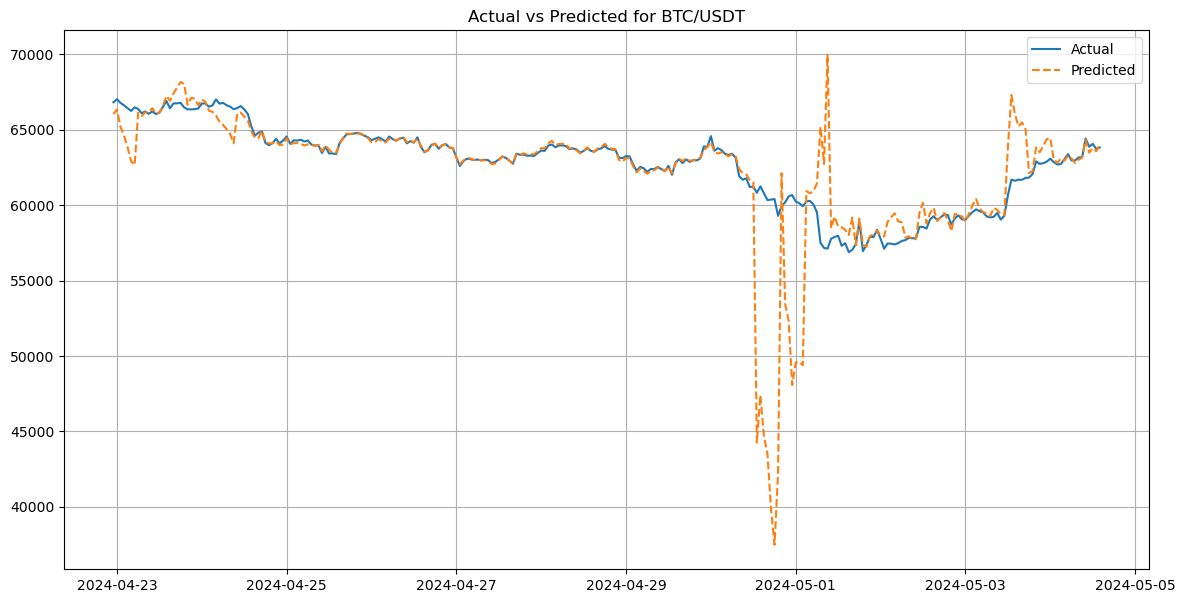

Data for ETH/USDT after dropping NaN values:
(301, 10)
Features (X) and target (y):
(301, 9) (301,)
Mean squared error for ETH/USDT: 123393.59


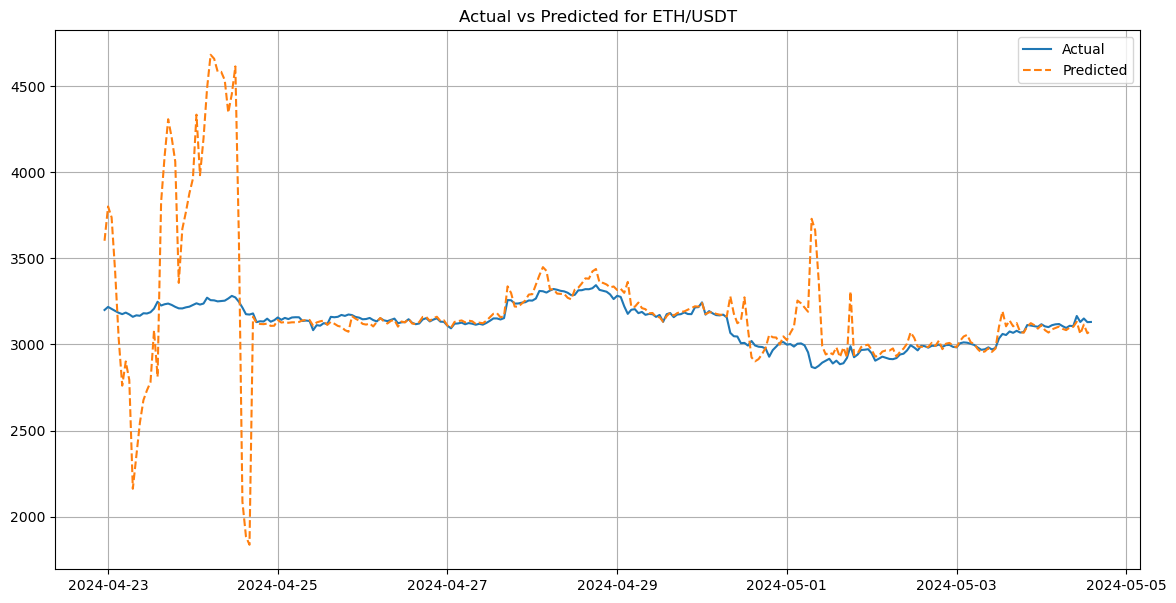

Data for DOT/USDT after dropping NaN values:
(301, 10)
Features (X) and target (y):
(301, 9) (301,)
Mean squared error for DOT/USDT: 0.79


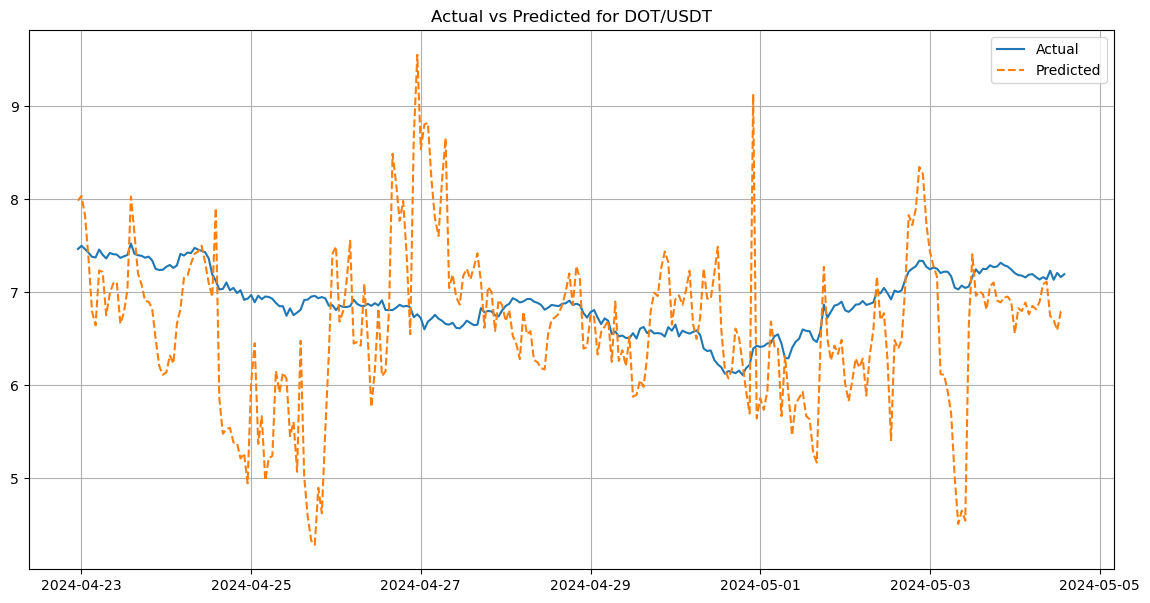

Data for ADA/USDT after dropping NaN values:
(301, 10)
Features (X) and target (y):
(301, 9) (301,)
Mean squared error for ADA/USDT: 0.00


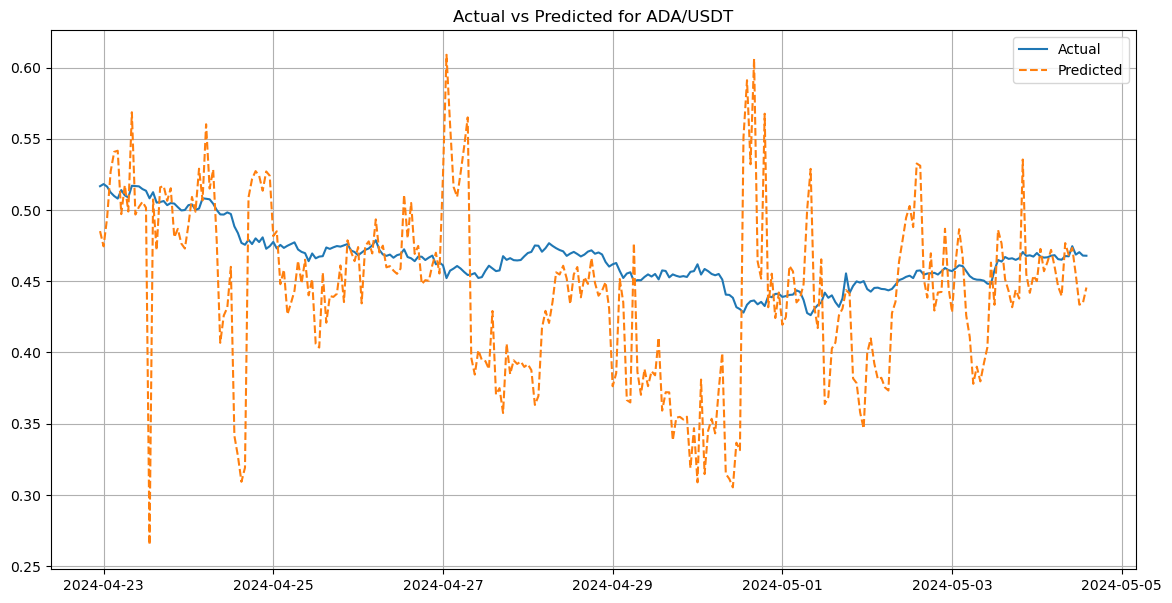

Data for SOL/USDT after dropping NaN values:
(301, 10)
Features (X) and target (y):
(301, 9) (301,)
Mean squared error for SOL/USDT: 837.40


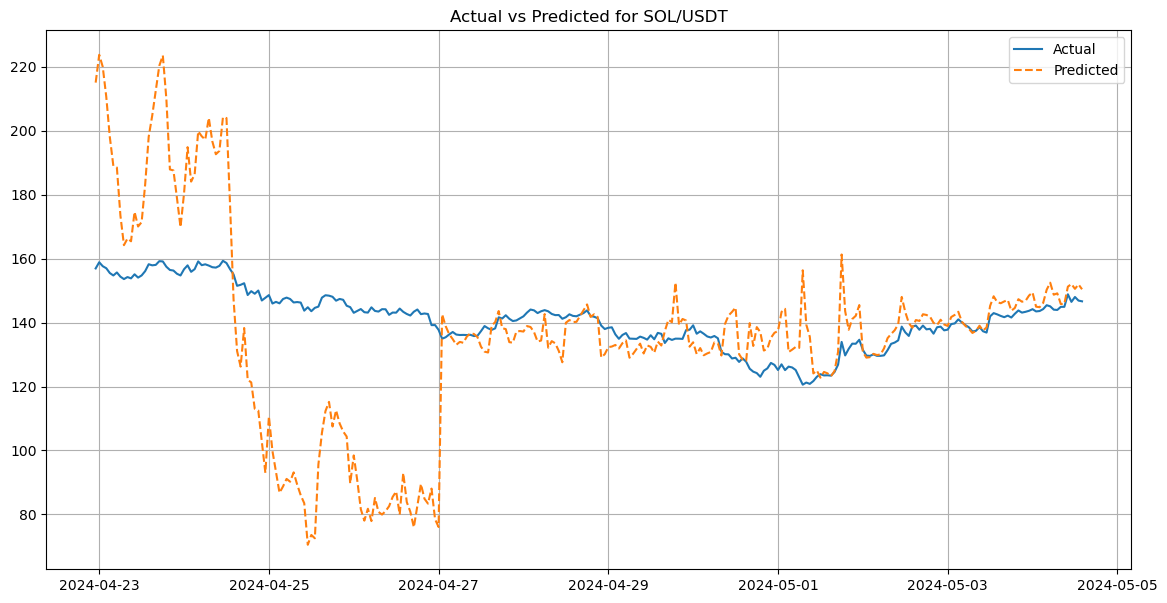

In [5]:
# Settings
symbols= ['BTC/USDT', 'ETH/USDT', 'DOT/USDT', 'ADA/USDT', 'SOL/USDT']
timeframe = '1h'
n_hours = 1000  # Number of hours to fetch data for (e.g., 300 hours)
since = exchange.parse8601(((datetime.utcnow()+ timedelta(hours=2)) - timedelta(hours=n_hours)).isoformat())


# Container for predictions
all_predictions = {}
# Fetch data

for symbol in symbols:   
    dataframe = fetch_ohlcv(symbol, timeframe=timeframe, since=since)
    
    # Add technical indicators
    dataframe['SMA_50'] = ta.trend.SMAIndicator(close=dataframe['close'], window=50).sma_indicator()
    dataframe['SMA_200'] = ta.trend.SMAIndicator(close=dataframe['close'], window=200).sma_indicator()
    dataframe['RSI_14'] = ta.momentum.RSIIndicator(close=dataframe['close'], window=14).rsi()
    bb = ta.volatility.BollingerBands(close=dataframe['close'], window=20, window_dev=2)
    dataframe['BB_High'] = bb.bollinger_hband()
    dataframe['BB_Low'] = bb.bollinger_lband()
    
    # Prepare data for machine learning
    dataframe = dataframe.dropna()  # Drop rows with NaN values

    # Check if data is not empty after dropping NaN values
    print(f"Data for {symbol} after dropping NaN values:")
    print(dataframe.shape)
    if dataframe.empty:
        raise ValueError(f"Dataframe for {symbol} is empty after dropping NaN values. Check data fetching and indicator calculation steps.")

    X = dataframe.drop(['close'], axis=1)
    y = dataframe['close']

    # Check if features and target are correctly separated
    print("Features (X) and target (y):")
    print(X.shape, y.shape)
    

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    
    

    # Model and cross-validation setup
    model = MLPRegressor(hidden_layer_sizes=(125, 125), max_iter=20000, alpha=0.002,learning_rate='adaptive',tol=0.002, learning_rate_init=0.002, random_state=42)
    n_samp=40
    tscv = TimeSeriesSplit(n_splits=n_samp)
    # Training and prediction
    predictions = []
    for train_index, test_index in tscv.split(X_scaled):
        X_train, X_test = X_scaled[train_index], X_scaled[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)        
        predictions.extend(y_pred)

    # Store predictions
    all_predictions[symbol] = predictions

    # Evaluate the model
    mse = mean_squared_error(y.iloc[-len(predictions):], predictions)
    print(f"Mean squared error for {symbol}: {mse:.2f}")
    # Plotting the results
    plt.figure(figsize=(14, 7))
    plt.plot(dataframe.index[-len(predictions):], y.iloc[-len(predictions):], label="Actual")
    plt.plot(dataframe.index[-len(predictions):], predictions, linestyle='dashed', label="Predicted")
    
    # Add vertical lines to show the train-test index borders
    #train_test_borders = int(len(X)/n_samp)
    #for border in range(train_test_borders):
        #plt.axvline(border, color='gray', linestyle='--')
    plt.grid(True)
    plt.title(f"Actual vs Predicted for {symbol}")
    plt.legend()
    plt.show()
    
    # Output all predictions
    #for symbol, predictions in all_predictions.items():
    #print(f"Predictions for {symbol}:\n", predictions)

    